久保拓弥『データ解析のための統計モデリング入門』をJuliaでやってみます。

* 久保さんの書籍ページ：http://hosho.ees.hokudai.ac.jp/~kubo/ce/IwanamiBook.html
* Amazon.co.jp：https://amzn.to/2Cg5vDJ

# 第7章「一般化線形混合モデル（GLMM） ---個体差のモデリング---」（途中）


In [1]:
using DataFrames
using CSV
using Distributions
using GLM
using Plots
pyplot()
using StatsPlots
using MixedModels
versioninfo()

Julia Version 1.1.0
Commit 80516ca202 (2019-01-21 21:24 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin14.5.0)
  CPU: Intel(R) Core(TM) i7-7920HQ CPU @ 3.10GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-6.0.1 (ORCJIT, skylake)


## 7.1 例題：GLMでは説明できないカウントデータ

In [2]:
d = CSV.read("data.csv")
describe(d)

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Float64,Int64,Float64,Int64,Nothing,Int64,DataType
1,N,8.0,8,8.0,8,,0,Int64
2,y,3.81,0,3.0,8,,0,Int64
3,x,4.0,2,4.0,6,,0,Int64
4,id,50.5,1,50.5,100,,0,Int64


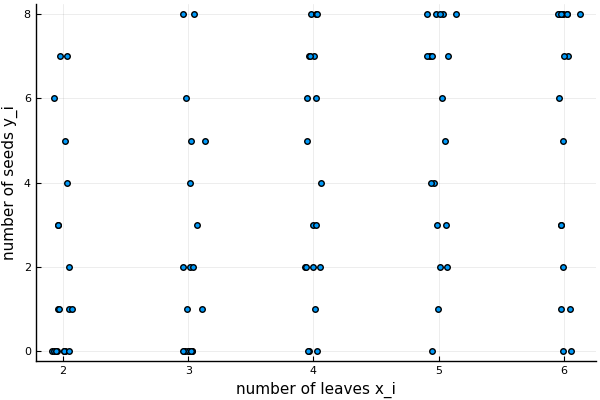

In [3]:
# Rでいうところのjitter()のためにrandn()を使っている
@df d scatter(:x .+ randn(size(:x))/20, :y,
    xlabel="number of leaves x_i", ylabel="number of seeds y_i", legend=false)

このデータについて、
$$\mathrm{logit}\left(q_i\right) = \beta_1 + \beta_2 x_i $$
$$p\left(y_i | \beta_1, \beta_2\right) = \binom{8}{y_i} q_i^{y_i}\left(1-q_i\right)^{8 - y_i} $$
を使ってパラメータ$\beta_1$と$\beta_2$の最尤推定を行う。

In [4]:
d[:y_ratio] = d[:y] ./ 8;
fit1 = glm(@formula(y_ratio ~ x), d, Binomial(), LogitLink())

StatsModels.DataFrameRegressionModel{GeneralizedLinearModel{GlmResp{Array{Float64,1},Binomial{Float64},LogitLink},DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: y_ratio ~ 1 + x

Coefficients:
             Estimate Std.Error  z value Pr(>|z|)
(Intercept)  -2.14874  0.670999 -3.20231   0.0014
x            0.510381  0.157268  3.24529   0.0012


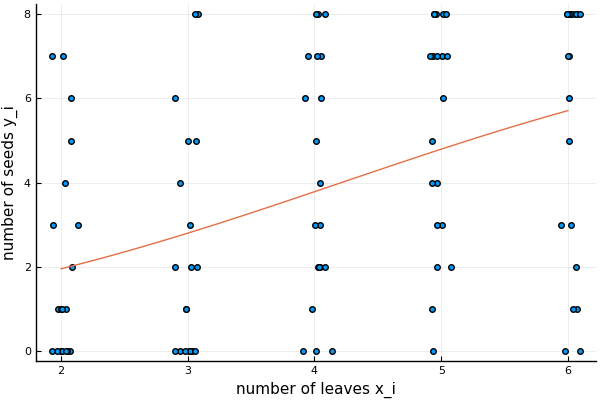

In [5]:
@df d scatter(:x .+ randn(size(:x))/20, :y,
    xlabel="number of leaves x_i", ylabel="number of seeds y_i", legend=false)

b1 = -2.14874
b2 = 0.510381
theta = 1 / b2
mu = -b1 * theta

newx = range(2.0, stop=6.0, step=0.1)
plot!(newx, cdf.(Logistic(mu, theta), newx) * 8)

パラメータ推定したものの、モデルのあてはまりが悪い。これはデータのばらつきが大きいから。

## 7.2 過分散と個体差

### 7.2.1 過分散：ばらつきが大きすぎる

期待されるよりも大きなばらつきのことを**過分散**（_over dispersion_）という。

In [11]:
d4 = d[d[:x] .== 4, :]

,N,y,x,id,y_ratio
,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Float64
1,8,6,4,41,0.75
2,8,2,4,42,0.25
3,8,0,4,43,0.0
4,8,5,4,44,0.625
5,8,6,4,45,0.75
6,8,2,4,46,0.25
7,8,8,4,47,1.0
8,8,2,4,48,0.25
9,8,7,4,49,0.875


In [19]:
using StatsBase
sort(countmap(d4[:y]))

OrderedCollections.OrderedDict{Union{Missing, Int64},Int64} with 9 entries:
  0 => 3
  1 => 1
  2 => 4
  3 => 2
  4 => 1
  5 => 1
  6 => 2
  7 => 3
  8 => 3

In [23]:
[mean(d4[:y]), var(d4[:y])]

2-element Array{Float64,1}:
 4.05             
 8.365789473684211

上記より生存確率は$4.05\div 8 \approx 0.5$と考えられるが、個数$n$・確率$p$のときの二項分布の平均は$np$・分散は$np\left(1-p\right)$なので、分散は$8 \times 0.5 \times \left(1-0.5\right)=2.0$となるのが想定される。しかし分散は8.37とかなり大きい。

### 7.2.2 観測されていない個体差がもたらす過分散